# Campaign Impact Analysis

TODO: write a short analysis objective

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

In [68]:
campaigns_df = pd.read_csv("../../data/processed/campaigns.csv")
customer_df = pd.read_csv("../../data/processed/customer.csv")
digital_usage_df = pd.read_csv("../../data/processed/digital_usage.csv")
engagement_details_df = pd.read_csv("../../data/processed/engagement_details.csv")
loans_df = pd.read_csv("../../data/processed/loans.csv")
products_owned_df = pd.read_csv("../../data/processed/products_owned.csv")
transactions_df = pd.read_csv("../../data/processed/transactions.csv")

print('Loaded Data Shapes:')
print('Campaign:', campaigns_df.shape)
print('Customer:', customer_df.shape)
print('DigitalUsage:', digital_usage_df.shape)
print('EngagementDetail:', engagement_details_df.shape)
print('Loan:', loans_df.shape)
print('ProductsOwned:', products_owned_df.shape)
print('Transaction:', transactions_df.shape)

Loaded Data Shapes:
Campaign: (99, 10)
Customer: (4000, 13)
DigitalUsage: (4000, 9)
EngagementDetail: (16000, 8)
Loan: (7920, 6)
ProductsOwned: (4000, 7)
Transaction: (5044, 5)


In [22]:
tables = {
    "Campaigns Data": campaigns_df,
    "Customer Data": customer_df,
    "Digital Usage Data": digital_usage_df,
    "Engagement Details": engagement_details_df,
    "Loans Data": loans_df,
    "Products Owned": products_owned_df,
    "Transactions Data": transactions_df,
}

for name, table in tables.items():
    print(f"Missing values in {name}:")
    print(table.isna().sum())

Missing values in Campaigns Data:
campaign_id           0
campaign_type         0
target_audience       0
campaign_duration     0
conversion_rate       0
acquisition_cost      0
roi                   0
campaign_language     0
impressions           0
clicks               16
dtype: int64
Missing values in Customer Data:
customer_id                0
age                        0
job                        0
marital                    0
education                  0
default                    0
balance                    0
debt                       0
income                     0
tenure                     0
nps                        0
dependents                 0
customer_lifetime_value    0
dtype: int64
Missing values in Digital Usage Data:
customer_id            0
has_mobile_app         0
has_web_account        0
mobile_logins_wk    1080
web_logins_wk        480
avg_mobile_time     1080
avg_web_time         480
last_mobile_use     1080
last_web_use         480
dtype: int64
Missing values

## KPI Computation

We focus on the following KPIs:

1. Engagement Rate: The percentage of engagement attempts that result in a successful engagement (`has_engaged == 1`).
2. Conversion Rate: Although the Campaign table provides a conversion rate, we also estimate a conversion rate by merging engagement data with transactions (assuming a conversion is reflected by a successful engagement that leads to a transaction).
3. Customer Lifetime Value (CLV): Analysis of the `customer_lifetime_value` column from the Customer table.

In addition, we segment by campaign type and channel to gain deeper insights.

### Engagement rate:
- What portion of our engagements were successful?
- What are the characteristics of a campaign with high engagement rate?
- Which communication channels have a higher chance of customer interaction?
- Are we allocating our engagement efforts to the appropriate customer segments?

Overall Engagement Rate: 22.23%


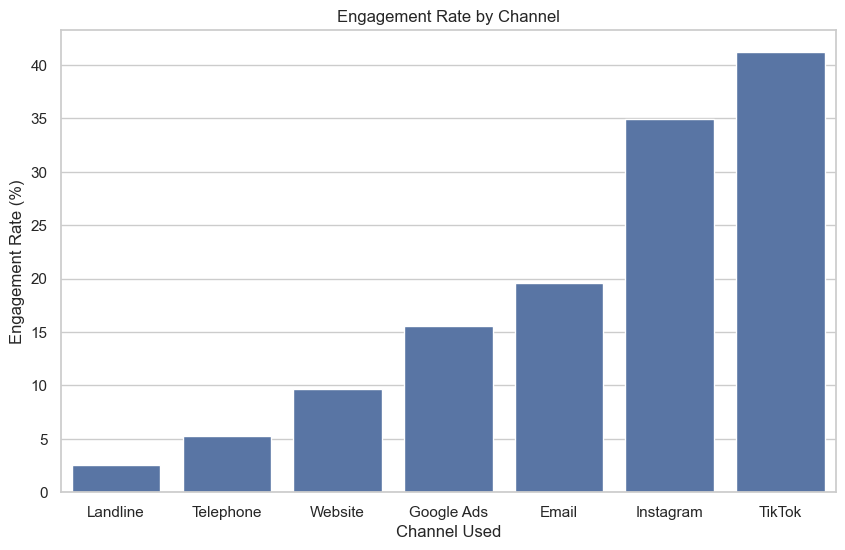

In [34]:
# Engagement rate overall
engagement_rate = engagement_details_df["has_engaged"].mean() * 100
print(f"Overall Engagement Rate: {engagement_rate:.2f}%")

# Engagement rate by communication channel used
engagement_campaign_df = engagement_details_df.merge(campaigns_df, on="campaign_id")
engagement_by_channel = engagement_campaign_df.groupby("channel_used")["has_engaged"].mean().sort_values() * 100

plt.figure(figsize=(10, 6))
sns.barplot(engagement_by_channel)
plt.title("Engagement Rate by Channel")
plt.xlabel("Channel Used")
plt.ylabel("Engagement Rate (%)")
plt.show()

It seems that while our average engagement rate is quite low at ~20%, this varies hugely by the channel used. Digital channels seem to perform better, especially social media platforms such as Tiktok and Instagram, which respond at ~40%, while tradional telemarketing has lower than 5% of success.

In [ ]:
# Shows 10 campaigns with the highest engagement rate
engagement_rate = engagement_campaign_df.groupby("campaign_id")["has_engaged"].mean() * 100
campaigns_df = campaigns_df.set_index("campaign_id")
campaigns_df["engagement_rate"] = engagement_rate
campaigns_df = campaigns_df.reset_index()

campaigns_df.nlargest(10, "engagement_rate")

,campaign_id,campaign_type,target_audience,campaign_duration,conversion_rate,acquisition_cost,roi,campaign_language,impressions,clicks,engagement_rate
53,55,Affiliate Marketing,35-44,60,0.1371,43031.70,3.52,French,33846,4640.0,43.406593
86,66,Display Advertising,55+,30,0.1270,29487.32,3.61,Spanish,27788,3529.0,43.150685
46,45,Display Advertising,35-44,75,0.1473,6760.62,4.75,German,19820,2919.0,42.514970
72,49,Affiliate Marketing,45-54,75,0.0587,11951.41,2.43,German,34410,2020.0,42.405063
9,34,Affiliate Marketing,35-44,60,0.0832,889.29,3.96,French,2259,188.0,41.772152
24,53,Affiliate Marketing,35-44,75,0.1000,12990.62,2.31,Spanish,41595,4160.0,41.610738
91,46,Display Advertising,45-54,60,0.0577,3819.54,2.20,German,11552,667.0,41.549296
2,41,Affiliate Marketing,35-44,30,0.1332,9051.65,1.99,Mandarin,7142,951.0,41.216216
74,50,Affiliate Marketing,45-54,45,0.0803,11064.79,1.83,German,21345,1714.0,40.828402
42,38,Display Advertising,18-24,45,0.0410,2244.33,4.25,Spanish,48230,1977.0,40.804598


The above shows the 10 campaigns with the highest engagement rate. All of them are digital campaigns, consistent with our findings from above. 

Surprisingly though, while we might expect the highest digital engagement from younger customer segments, most of these successful campaigns targeted middle-aged adults. None of them were English campaigns.

TODO: add a possible explanation and action

In [26]:
engagement_details_df.merge(campaigns_df, on="campaign_id").groupby("campaign_type")["channel_used"].value_counts()

campaign_type               channel_used
Affiliate Marketing         TikTok          1352
                            Instagram       1335
Display Advertising         Website         2200
                            TikTok          1774
                            Instagram       1641
                            Google Ads       964
Email Marketing             Email           2908
Search Engine Optimization  Google Ads      1242
Telemarketing               Telephone       1303
                            Landline        1281
Name: count, dtype: int64

### Conversion rate


**TODO:** use customer segmentation model by Teresa to check if we are targeting customers appropriately